In [246]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import astropy.units as u
import astropy.io.fits as fits

import glob

# Holy shit it worked.

from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.Bandpass import Bandpass 
# Well, it kind of worked. For some reason have to do it this way, with two lines instead of one, or it returns
# a "ModuleNotFoundError - No module named lsst.utils", or something to that effect.

import os

In [247]:
# Grab the current directory
cwd = os.getcwd()
# just one dir to start
directory = os.path.join(cwd, 'ckm05')
filepath = glob.glob(os.path.join(directory,'*.fits'))

In [248]:
# 
hdul = fits.open(filepath[-11])
# The header says what the 
header = hdul[0].header.copy()
spec_table = hdul[1].data.copy()
hdul.close()

In [249]:
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    0 / Number of axes                                 
EXTEND  =                    T / File may contain extensions                    
DATE    = '2007-01-09T16:25:07' / Date FITS file was generated                  
IRAF-TLM= '11:25:19 (09/01/2007)' / Time of last modification                   
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'STScI-STSDAS/TABLES' / Tables version 2002-02-22                     
FILENAME= 'ckm05_7250.fits'    / name of file                                   
NEXTEND =                    1 / number of extensions in file                   
TEFF    =                 7250                                                  
LOG_Z   =                 -0

(1000, 10000)

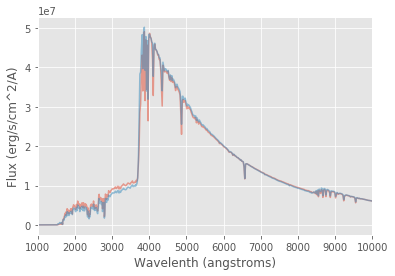

In [250]:
# Let's see what a few of them look like
plt.plot(spec_table['WAVELENGTH'], spec_table['g15'], alpha=0.5)
plt.plot(spec_table['WAVELENGTH'], spec_table['g05'], alpha=.5)
# Always always keep track of units!
plt.xlabel('Wavelenth (angstroms)')
plt.ylabel('Flux (erg/s/cm^2/A)')
plt.xlim([1000,10000])

In [251]:
# OK, those look like stellar spectra I can believe in.

In [252]:
# Had to comment out the os functions and import the filters using my specific directory stuff.
# Python couldn't find LSST_THROUGHPUTS_BASELINE and this was just the quickest way to troubleshoot.

band_dir = '/Users/ichorgodbel-shamroth/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/throughputs/2017.01.31-6-g29ce4f5/baseline/'

In [253]:
# LSST standard is nm rather than Ang. I think I did this right.
my_sed = Sed(wavelen=spec_table['WAVELENGTH']/10., flambda=spec_table['g15']*10)

In [254]:
# now to read in an LSST bandpass

#band_dir = os.getenv("LSST_THROUGHPUTS_BASELINE")

filterlist =['u', 'g', 'r', 'i', 'z', 'y']
bps = []
for filtername in filterlist:
    tempB = Bandpass()
    #tempB.readThroughput(os.path.join(band_dir, 'filter_'+filtername+'.dat'))
    tempB.readThroughput(band_dir+'filter_'+filtername+'.dat')
    bps.append(tempB)

In [255]:
bps

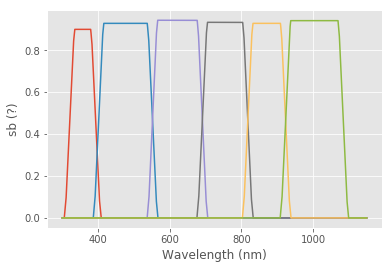

In [256]:
# Let's plot a few bandpass objects to make sure they look right
for bp in bps:
    plt.plot(bp.wavelen, bp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

In [257]:
for filtername, bp in zip(filterlist, bps):
    print(filtername, my_sed.calcMag(bp))

u -38.363286413963436
g -39.59327802655636
r -39.52419558206158
i -39.41067490412371
z -39.38876055845057
y -39.351077441196864


In [258]:
# OK, that looks scary (because the sun only has an apparent mag of -27), but we never said 
#what distance the stars are at. So we can just add a constant to all the mags and it's fine.


Some good next steps:
* grab the narrow band filter throughputs from that survey, and figure out how to read them into bandpass objects - check
* Once we have all the filters and the stellar spectra, time to build a giant array! Each row would have star Teff, logg, metallicity, and then magnitudes in each LSST filter and narrowband filter. Can save the whole thing as a numpy zip file for easy reloading

# SPLUS Survey Narrowband Filters:

In [259]:
splus_filt_dir = os.path.join(cwd, 'splus_filter_curves/')

In [260]:
narrowbandfiltlist = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']

splus_narrowbands = []

# Only problem with getting the splus survey narrowbands to fit into the Bandpass object was
# that I needed to specify a max and min wavelength for some reason. Once they were explicitly
# defined, however, it went pretty smoothly.

for filtername in narrowbandfiltlist:
    tempB2 = Bandpass(wavelen_min=3000, wavelen_max=9000)
    tempB2.readThroughput(splus_filt_dir+filtername+'.dat')
    splus_narrowbands.append(tempB2)

In [261]:
splus_narrowbands

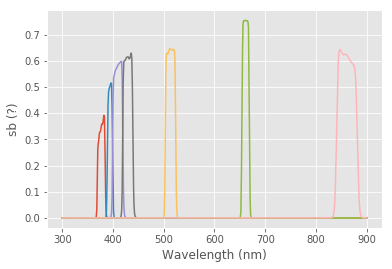

In [262]:
# plotting again to make sure they've come out right

for bp in splus_narrowbands:
    plt.plot(bp.wavelen/10, bp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

In [263]:
# judging by the plot, the magnitudes, and the magitudes from your example, it looks right\

for filtername, bp in zip(narrowbandfiltlist, splus_narrowbands):
    print(filtername, my_sed.calcMag(bp))

F378 -37.24489716943626
F395 -37.165925637468774
F410 -37.08693588648791
F430 -36.99837481416216
F515 -36.63665694365109
F660 -36.12280452787408
F861 -35.573271981260476


# Experimentation:

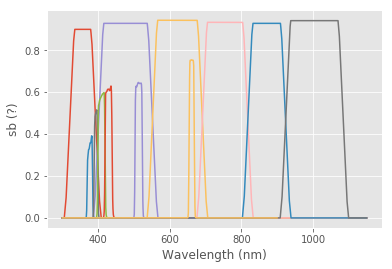

In [264]:
# Plotting it this way cuts off the last (~8500-9000 angstrom) filter. No idea why.

for bp, nbp in zip(bps, splus_narrowbands):
    plt.plot(bp.wavelen, bp.sb, nbp.wavelen/10, nbp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

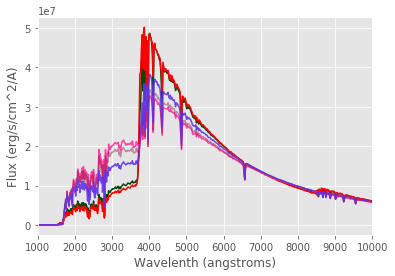

In [265]:
# messing around with the fits files and the spectra contained within.
# Not sure I get what the different log(g) values entail, exactly

plt.plot(spec_table['WAVELENGTH'], spec_table['g15'], alpha=1.0, color='xkcd:british racing green')
plt.plot(spec_table['WAVELENGTH'], spec_table['g05'], alpha=1.0, color='r')
plt.plot(spec_table['WAVELENGTH'], spec_table['g50'], alpha=1.0, color='xkcd:barbie pink')
plt.plot(spec_table['WAVELENGTH'], spec_table['g45'], alpha=0.4, color='xkcd:bordeaux')
plt.plot(spec_table['WAVELENGTH'], spec_table['g35'], alpha=0.9, color='xkcd:purpley blue')

plt.xlabel('Wavelenth (angstroms)')
plt.ylabel('Flux (erg/s/cm^2/A)')
plt.xlim([1000,10000]);

In [266]:
plt.style.use('ggplot')

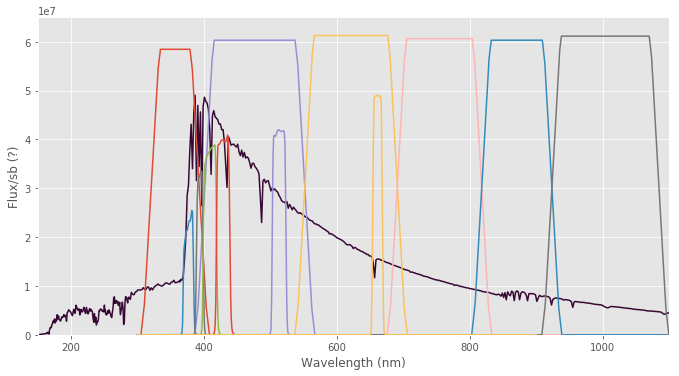

In [267]:
# y-axis is a mess here, but wanted one of the spectra and the filter bands overlaid

fig,ax = plt.subplots(1,1)                 
fig.set_size_inches(9.5,5)                  

fig.tight_layout()                          

ax.set_xlim(150,1100)
ax.set_ylim(0,6.5*10**7)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux/sb (?)")

ax.plot(spec_table['WAVELENGTH']/10, spec_table['g15'], alpha=1.0, color='xkcd:eggplant')
for bp, nbp in zip(bps, splus_narrowbands):
    ax.plot(bp.wavelen, bp.sb*6.5*10**7, nbp.wavelen/10, nbp.sb*6.5*10**7);

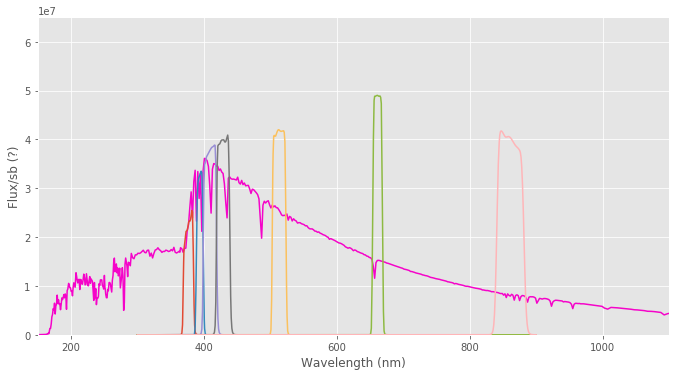

In [268]:
# now just for the narrowbands

fig,ax = plt.subplots(1,1)                 
fig.set_size_inches(9.5,5)                  

fig.tight_layout()                          


ax.set_xlim(150,1100)
ax.set_ylim(0,6.5*10**7)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux/sb (?)")

# just pretend that in the case of the filter bands, 6.5*10^7 is the same thing as 1

ax.plot(spec_table['WAVELENGTH']/10, spec_table['g40'], alpha=1.0, color='xkcd:hot magenta')
for bp in splus_narrowbands:
    ax.plot(bp.wavelen/10, bp.sb*6.5*10**7);

# Putting the Bits Together:

In [269]:
# mainly to remind myself what goes in the array

giant_array_cols = ['Teff', 'log(g)', 'Metallicity', 'u', 'g', 'r', 'i', 'z', 'y', 
               'F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']

In [270]:
# T_eff/metallicity for each star in the ckm05 directory. Of course as every log_Z is -1/2, that
# one is not particularly exciting in this case:

for filename in filepath:
    hdul2 = fits.open(filename)
    header1 = hdul2[0].header.copy()
    spec_table1 = hdul2[1].data.copy()
    hdul2.close()
    teff = header1['TEFF']
    hella_metal = header1['LOG_Z']
    for filtername, bp in zip(narrowbandfiltlist, splus_narrowbands):
        # took Z out of log form, but maybe there's no point...
        modest_array = [teff, '{0:.2f}'.format(10**(hella_metal))]
    print(modest_array)

[10000, '0.32']
[10250, '0.32']
[10500, '0.32']
[10750, '0.32']
[11000, '0.32']
[11250, '0.32']
[11500, '0.32']
[11750, '0.32']
[12000, '0.32']
[12250, '0.32']
[12500, '0.32']
[12750, '0.32']
[13000, '0.32']
[14000, '0.32']
[15000, '0.32']
[16000, '0.32']
[17000, '0.32']
[18000, '0.32']
[19000, '0.32']
[20000, '0.32']
[21000, '0.32']
[22000, '0.32']
[23000, '0.32']
[24000, '0.32']
[25000, '0.32']
[26000, '0.32']
[27000, '0.32']
[28000, '0.32']
[29000, '0.32']
[30000, '0.32']
[31000, '0.32']
[32000, '0.32']
[33000, '0.32']
[34000, '0.32']
[3500, '0.32']
[35000, '0.32']
[36000, '0.32']
[37000, '0.32']
[3750, '0.32']
[38000, '0.32']
[39000, '0.32']
[4000, '0.32']
[40000, '0.32']
[41000, '0.32']
[42000, '0.32']
[4250, '0.32']
[43000, '0.32']
[44000, '0.32']
[4500, '0.32']
[45000, '0.32']
[46000, '0.32']
[47000, '0.32']
[4750, '0.32']
[48000, '0.32']
[49000, '0.32']
[5000, '0.32']
[50000, '0.32']
[5250, '0.32']
[5500, '0.32']
[5750, '0.32']
[6000, '0.32']
[6250, '0.32']
[6500, '0.32']
[6750

### General reminder to myself re: procedure: for each spectrum in each of the directories, need T_eff, metallicity, & magnitudes in each narrowband & lsst filter at each value of log(g).

In [271]:
# just wanted to check what was in the second header, hoped there might be a log_g there...

hdul = fits.open(filepath[-11])
header3 = hdul[1].header.copy()
hdul.close()

header3

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   48 / width of table in bytes                        
NAXIS2  =                 1221                                                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   12                                                  
TTYPE1  = 'WAVELENGTH'         / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'ANGSTROM'           / physical unit of field                         
TTYPE2  = 'g00     '           / label for field   2                            
TFORM2  = '1E      '        

In [272]:
# biggest current problem: writing the proper loop to get each gravity for each spectrum

In [273]:
# aside from formatting it correctly, need to include the "0 flux" band spectra, as it
# is there's a good deal of them missing. Does having so many 0 flux bands even make sense?

for filename in filepath:
    hdul2 = fits.open(filename)
    header1 = hdul2[0].header.copy()
    spec_table1 = hdul2[1].data.copy()
    my_seds = Sed(wavelen=spec_table1['WAVELENGTH']/10, flambda=spec_table1['g00']*10)
    hdul2.close()
    for filtername, bp in zip(filterlist, bps):
        flux = my_seds.calcFlux(bp)
        if flux > 0:
            print(filtername, my_seds.calcMag(bp))

u -29.424482651491875
g -33.50192395062531
r -35.081438973249874
i -35.957555404050225
z -36.41126851757147
y -36.74240179856483
u -30.362596735410907
g -34.4203501822513
r -35.89258057575029
i -36.48212182457108
z -36.79455788431568
y -37.04958830383141
u -31.47331174448487
g -35.16429108189783
r -36.450273081912485
i -36.91238600478107
z -37.15246579678751
y -37.357521503151574
u -32.50757428809138
g -35.7621715952956
r -36.901299012733006
i -37.28226134307518
z -37.47081266232716
y -37.63488588094992
u -33.393418879758386
g -36.26345550734443
r -37.28278396360717
i -37.60873741247926
z -37.7533001861252
y -37.883438343344096
u -34.17618869165693
g -36.714879244342654
r -37.611544870138104
i -37.893773195219296
z -38.00281625434479
y -38.10463127981005
u -34.893165496495655
g -37.13687989530814
r -37.90086551351885
i -38.1378516274097
z -38.2194644340248
y -38.29739227292416
u -35.53609848355231
g -37.530648935652295
r -38.15923785136661
i -38.346485201638586
z -38.40689941580389
y -

In [274]:
# seems to be less of an issue for the higher log_g ones, so that's nice

for filename in filepath:
    hdul2 = fits.open(filename)
    header1 = hdul2[0].header.copy()
    spec_table1 = hdul2[1].data.copy()
    my_seds = Sed(wavelen=spec_table1['WAVELENGTH']/10, flambda=spec_table1['g50']*10)
    hdul2.close()
    for filtername, bp in zip(narrowbandfiltlist, splus_narrowbands):
        flux = my_seds.calcFlux(bp)
        #if flux > 0:
        print(filtername, my_seds.calcMag(bp))

F378 -37.59849232250147
F395 -37.52377611929069
F410 -37.434742643996145
F430 -37.34973321378159
F515 -36.97732591524185
F660 -36.4634608482168
F861 -35.90200805405081
F378 -37.62102205295311
F395 -37.54596987353082
F410 -37.457009295696395
F430 -37.37174026420256
F515 -36.99896449423116
F660 -36.484455771178176
F861 -35.92263079374639
F378 -37.64327178965182
F395 -37.56779325255678
F410 -37.47897822522765
F430 -37.39339434245795
F515 -37.02024392651296
F660 -36.50517288678712
F861 -35.94308939762027
F378 -37.66538625164087
F395 -37.589454460449616
F410 -37.50083281034088
F430 -37.41490298135683
F515 -37.04154934006512
F660 -36.52563605688563
F861 -35.96339916427765
F378 -37.687361239894486
F395 -37.61100096173939
F410 -37.522595634896376
F430 -37.436269247450795
F515 -37.06269770659277
F660 -36.54607162725294
F861 -35.9837494002749
F378 -37.70915645821556
F395 -37.63223942334345
F410 -37.544168543145204
F430 -37.45742423559321
F515 -37.08362118574499
F660 -36.56650851595131
F861 -36.0

F378 -39.39166604426815
F395 -39.29975573060139
F410 -39.21435979110029
F430 -39.11399696611518
F515 -38.72283227887809
F660 -38.16988281065271
F861 -37.59056794062067
F378 -39.411962136672315
F395 -39.319974566529424
F410 -39.23461586068484
F430 -39.13412540050675
F515 -38.742911329964315
F660 -38.18975854298266
F861 -37.6102901692109
F378 -36.80336981700805
F395 -36.71949803857434
F410 -36.64374130573712
F430 -36.52254585562842
F515 -36.13202278694253
F660 -35.67124112142692
F861 -35.126260646262
F378 -39.431752753611505
F395 -39.33962584025004
F410 -39.25431940142552
F430 -39.15383459303325
F515 -38.76241185185235
F660 -38.20886991236087
F861 -37.62940869451393
F378 -39.450951373744374
F395 -39.35881321479627
F410 -39.2734396212942
F430 -39.172796493467246
F515 -38.78131025087416
F660 -38.22747522552987
F861 -37.6476613202299
F378 -36.86465303644131
F395 -36.78036761973941
F410 -36.70400492260039
F430 -36.587788122293276
F515 -36.20303890602354
F660 -35.73100682430328
F861 -35.18560

### To summarize: need to format the magnitudes properly, and figure out the log_g loop. It's these two steps that I could use some help with.